In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics 
import scipy.stats as stats
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
sns.set(rc={'figure.figsize':(11, 4)})
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import KFold, cross_val_score as CVS
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn import tree
from sklearn.metrics import r2_score
from xgboost import XGBRegressor as XGBR
import xgboost as xgb
from sklearn.model_selection import GridSearchCV as GCV
from time import time
import datetime

In [2]:
df=pd.read_csv('others_outlier_dataset.csv')
df['deliverydate'] = pd.to_datetime(df['deliverydate'],format = "%Y-%m-%d")
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   deliverydate  270 non-null    datetime64[ns]
 1   shippedqty    270 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.3 KB


,deliverydate,shippedqty
0,2021-01-02,1993564.0
1,2021-01-03,34037.0
2,2021-01-04,1247476.0
3,2021-01-05,2172283.0
4,2021-01-06,2168990.0
...,...,...
265,2021-12-27,2195944.0
266,2021-12-28,1048536.0
267,2021-12-29,1282324.0
268,2021-12-30,998800.0


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
shippedqty,270.0,1.377418e+06,865144.772588,1632.0,565349.0,1450514.5,2168158.5,2776594.0


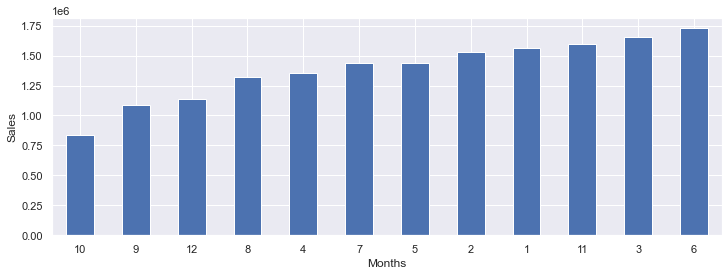

In [4]:
fig, axs = plt.subplots(figsize=(12, 4))
df.groupby(df["deliverydate"].dt.month)["shippedqty"].mean().sort_values(ascending=True).plot(kind='bar', rot=0, ax=axs)
plt.xlabel("Months");  # custom x label using Matplotlib
plt.ylabel("Sales");

In [5]:
df['week_days'] = df['deliverydate'].dt.day_name()
df = df[['deliverydate', 'week_days', 'shippedqty']]
df

,deliverydate,week_days,shippedqty
0,2021-01-02,Saturday,1993564.0
1,2021-01-03,Sunday,34037.0
2,2021-01-04,Monday,1247476.0
3,2021-01-05,Tuesday,2172283.0
4,2021-01-06,Wednesday,2168990.0
...,...,...,...
265,2021-12-27,Monday,2195944.0
266,2021-12-28,Tuesday,1048536.0
267,2021-12-29,Wednesday,1282324.0
268,2021-12-30,Thursday,998800.0


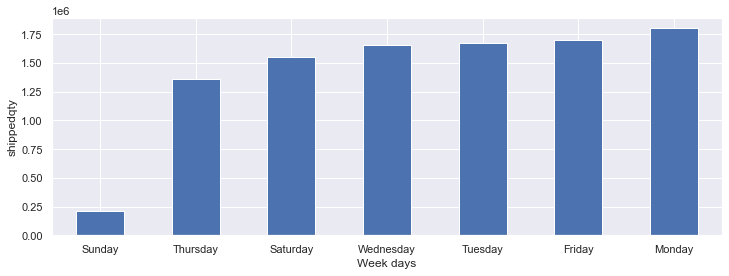

In [6]:
fig, axs = plt.subplots(figsize=(12, 4))
df.groupby(df["week_days"])["shippedqty"].mean().sort_values(ascending=True).plot(kind='bar', rot=0, ax=axs)
plt.xlabel("Week days"); 
plt.ylabel("shippedqty");

In [7]:
k = df.resample('3D', on='deliverydate').shippedqty.sum()
k

deliverydate
2021-01-02    3275077.0
2021-01-05    4777894.0
2021-01-08      86987.0
2021-01-11    2099304.0
2021-01-14    2163205.0
                ...    
2021-12-19     288620.0
2021-12-22    4272362.0
2021-12-25    2360460.0
2021-12-28    3329660.0
2021-12-31     876910.0
Freq: 3D, Name: shippedqty, Length: 122, dtype: float64

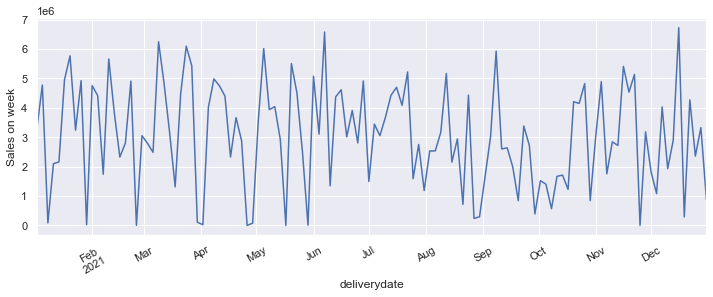

In [8]:
fig, axs = plt.subplots(figsize=(12, 4))
k.plot(kind='line', rot=30, ax=axs)
plt.xlabel("deliverydate");  
plt.ylabel("Sales on week");

In [9]:
df1 = df.copy()
df1

,deliverydate,week_days,shippedqty
0,2021-01-02,Saturday,1993564.0
1,2021-01-03,Sunday,34037.0
2,2021-01-04,Monday,1247476.0
3,2021-01-05,Tuesday,2172283.0
4,2021-01-06,Wednesday,2168990.0
...,...,...,...
265,2021-12-27,Monday,2195944.0
266,2021-12-28,Tuesday,1048536.0
267,2021-12-29,Wednesday,1282324.0
268,2021-12-30,Thursday,998800.0


In [10]:
df1["rolling_qty_7D"] = df1['shippedqty'].rolling(window= 7, min_periods=1).sum().astype(int)
df1["rolling_sales_14D"] = df1['shippedqty'].rolling(window= 14, min_periods=1).sum().astype(int)

In [11]:
df = df1.copy()
rowcount  = 0
for row in open("others_outlier_dataset.csv"):
    rowcount+= 1
print("Number of rows present:", rowcount)
rows=int(rowcount*0.3)
train=df.iloc[:-rows]
test=df.iloc[-rows:]
print('Train Dataset:',train.shape)
print('Test Dataset:',test.shape)


Number of rows present: 271
Train Dataset: (189, 5)
Test Dataset: (81, 5)


In [12]:
b = []
for i in train.keys():
    b.append(i)
print(b) 

['deliverydate', 'week_days', 'shippedqty', 'rolling_qty_7D', 'rolling_sales_14D']


In [13]:
b.remove('week_days')
b.remove('deliverydate')
print(b)

['shippedqty', 'rolling_qty_7D', 'rolling_sales_14D']


In [14]:
X_train = train[b].values
X_test = test[b].values
y_train = train['shippedqty'].values
y_test = test['shippedqty'].values
X_test.shape

(81, 3)

In [15]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train,y_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

## (N_estimators)

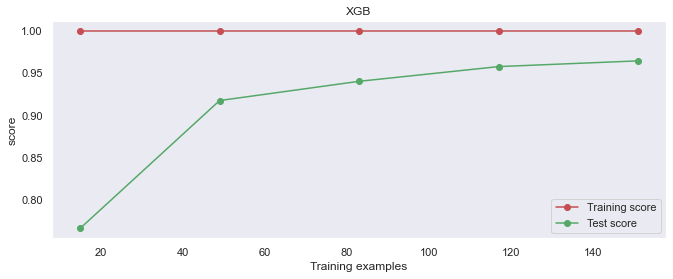

In [16]:
def plot_learning_curve(estimator, title, train, test,ax=None,ylim=None,cv=None,n_jobs=None):
    from sklearn.model_selection import learning_curve
    train_sizes, train_scores, test_scores = learning_curve(estimator, train, test,shuffle=True,cv=cv,random_state=420,n_jobs=n_jobs)
    if ax == None:
        ax = plt.gca()
    else:
        ax = plt.figure()
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel ("Training examples")
    ax.set_ylabel("score")
    ax.grid()
    ax.plot(train_sizes, np.mean(train_scores, axis=1),"o-",color="r", label="Training score")
    ax.plot(train_sizes, np.mean(test_scores, axis=1), 'o-',color="g", label="Test score")
    ax. legend (loc="best")
    return ax
cv = KFold(n_splits=5, shuffle = True, random_state=42)
plot_learning_curve(XGBR(n_estimators=100, random_state=420), "XGB" , X_train, y_train, ax=None, cv=cv)
plt. show()

140 0.9640390995220735 0.9640390995220735
10 0.9481670095963661 0.9481670095963661
210 0.9640390870095571 0.9640390870095571 0.0016389916537894378


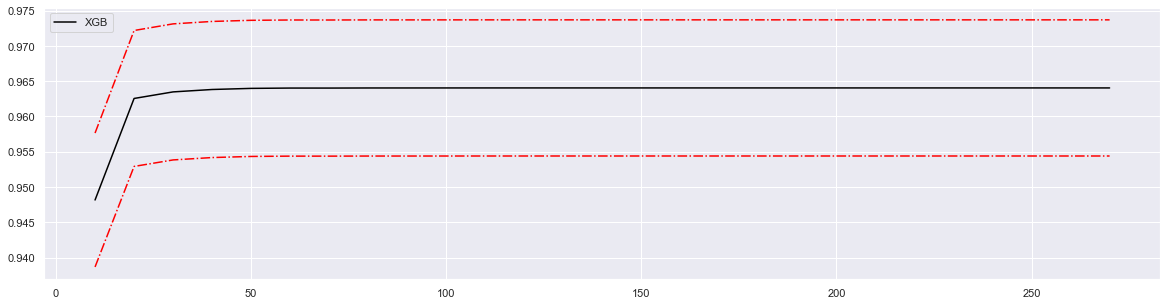

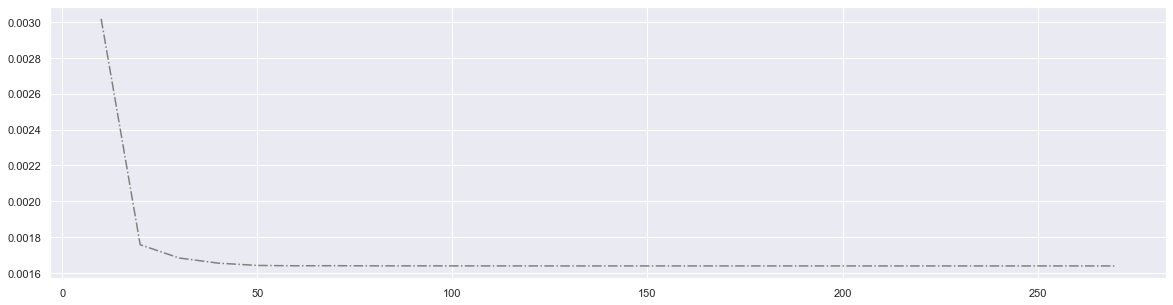

In [17]:
axisx=range(10,rowcount,10)
rs=[]
var=[]
ge=[]
for i in axisx:
    reg=XGBR(n_estimators=i,random_state=420)
    cvresult=CVS(reg,X_train,y_train,cv=cv)
    rs.append(cvresult.mean())
    var.append(cvresult.mean())
    ge.append((1-cvresult.mean())**2+cvresult.var())
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
rs=np.array(rs)
var=np.array(var)*0.01
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c='Black',label='XGB')
plt.plot(axisx,rs+var,c="red",linestyle="-.")
plt.plot(axisx,rs-var,c="red",linestyle="-.")
plt.legend()
plt.show()
plt.figure(figsize=(20,5))
plt.plot(axisx,ge,c="gray",linestyle="-.")
plt.show()

In [19]:
time0 = time()
print(XGBR(n_estimators=100,random_state=420).fit(X_train,y_train).score(X_test,y_test))
print(time()-time0)

0.9076239668749978
0.15973496437072754


In [18]:
time0 = time()
print(XGBR(n_estimators=210,random_state=420).fit(X_train,y_train).score(X_test,y_test))
print(time()-time0)

0.9236979665629871
0.21656084060668945


In [19]:
time0 = time()
print(XGBR(n_estimators=80,random_state=420).fit(X_train,y_train).score(X_test,y_test))
print(time()-time0)

0.9236016695702841
0.13745880126953125


In [20]:
time0 = time()
print(XGBR(n_estimators=75,random_state=420).fit(X_train,y_train).score(X_test,y_test))
print(time()-time0)

0.9236238590508941
0.11705398559570312


## (Subsample)

0.2 0.9795554445997932 0.9795554445997932
0.05 0.9625693335037026 0.9625693335037026
0.25 0.9792604268632255 0.9792604268632255 0.00044674295261477664


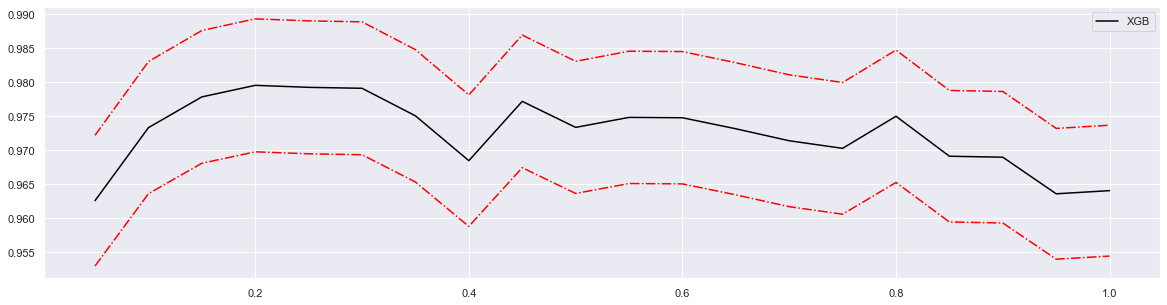

In [21]:
axisx=np.linspace(0.05,1,20)
rs=[]
var=[]
ge=[]
for i in axisx:
    reg=XGBR(n_estimators=210,subsample=i,random_state=420)
    cvresult=CVS(reg,X_train,y_train,cv=cv)
    rs.append(cvresult.mean())
    var.append(cvresult.mean())
    ge.append((1-cvresult.mean())**2+cvresult.var())
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
rs=np.array(rs)
var=np.array(var)*0.01
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c='Black',label='XGB')
plt.plot(axisx,rs+var,c="red",linestyle="-.")
plt.plot(axisx,rs-var,c="red",linestyle="-.")
plt.legend()
plt.show()

In [24]:
reg=XGBR(n_estimators=210,subsample=0.25,random_state=420).fit(X_train,y_train)

In [25]:
reg.score(X_test,y_test)

0.9541907559348446

In [26]:
MSE(y_test,reg.predict(X_test))

31337355994.674526

## (Scoring)

In [27]:
def regassess(reg,X_train,y_train,cv,scoring=['r2'],show=True):
    score=[]
    for i in range(len(scoring)):
        if show:
            print("{}:{:.2f}".format(scoring[i],CVS(reg,X_train,y_train ,cv=cv,scoring=scoring[i]).mean()))
        score.append(CVS(reg,X_train,y_train,cv=cv,scoring=scoring[i]).mean())
    return score

In [28]:
regassess(reg,X_train,y_train,cv,scoring=['r2','neg_mean_squared_error'])

r2:0.98
neg_mean_squared_error:-14662976531.68


[0.9792604268632255, -14662976531.684826]

In [29]:
for i in [0,0.15,0.2,0.25,0.35,1]:
    time0=time()
    reg = XGBR(n_estimators=210,random_state=420,learning_rate=i)
    print("learning_rate = {}".format(i))
    regassess(reg,X_train,y_train,cv,scoring = ["r2","neg_mean_squared_error"])
    print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))
    print("\t")

learning_rate = 0
r2:-3.16
neg_mean_squared_error:-2922229966528.72
00:01:756100
	
learning_rate = 0.15
r2:0.96
neg_mean_squared_error:-25785292551.41
00:02:084301
	
learning_rate = 0.2
r2:0.97
neg_mean_squared_error:-24205703843.35
00:01:856894
	
learning_rate = 0.25
r2:0.96
neg_mean_squared_error:-28264608446.71
00:02:156060
	
learning_rate = 0.35
r2:0.96
neg_mean_squared_error:-25615227642.56
00:02:023849
	
learning_rate = 1
r2:0.91
neg_mean_squared_error:-67942567391.67
00:01:299996
	


0.2 0.9663910963191734


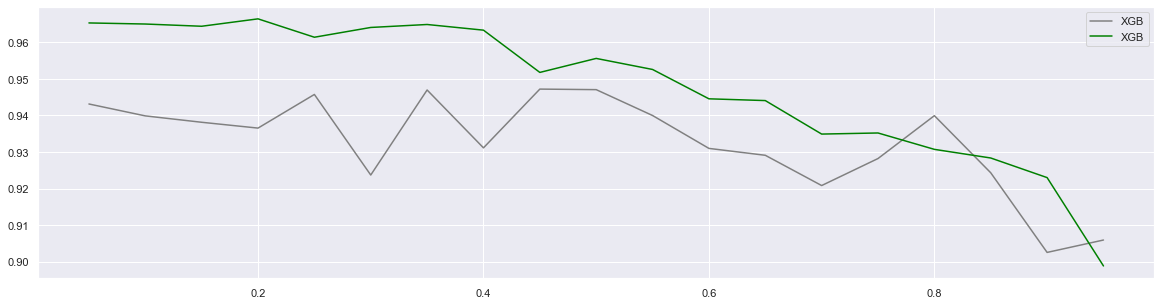

In [30]:
axisx=np.arange(0.05,1,0.05)
rs=[]
te=[]
for i in axisx:
    reg = XGBR(n_estimators=260,random_state=420,learning_rate=i)
    score = regassess(reg,X_train,y_train,cv,scoring =["r2","neg_mean_squared_error"],show=False)
    test = reg.fit(X_train,y_train).score(X_test,y_test)
    rs.append(score[0])
    te.append(test)
print(axisx[rs.index(max(rs))],max(rs))
plt.figure(figsize=(20,5))
plt.plot(axisx,te,c="gray",label="XGB")
plt.plot(axisx,rs,c="green",label="XGB")
plt.legend()
plt.show()

## (booster)

In [31]:
for booster in ["gbtree","gblinear","dart"]:
    reg = XGBR(n_estimators=210,learning_rate=0.2,random_state=420,booster=booster).fit(X_train,y_train)
    print(booster)
    print(reg.score(X_test,y_test))

gbtree
0.9365252427251388
gblinear
0.9999999999999575
dart
0.9365252427251388


## (Objective)

In [32]:
reg=XGBR(n_estimators=210,random_state=420).fit(X_train,y_train)
reg.score(X_test,y_test)
MSE(y_test,reg.predict(X_test))

52196975386.284874

In [35]:
dtrain=xgb.DMatrix(X_train,y_train)
dtest=xgb.DMatrix(X_test,y_test)
dtrain

In [36]:
param={'silent':True,
       'objective':'reg:linear'
       ,'eta':0.15}
num_round=210

### shift+tab can see the function of the code

In [37]:
bst=xgb.train(param,dtrain,num_round)

[15:48:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [38]:
preds=bst.predict(dtest)
print('r2:',r2_score(y_test,preds))
print('MSE:',MSE(y_test,preds))

r2: 0.9381193858530281
MSE: 42331517890.46382


## （Gamma->Complexity control)

2.5500000000000003 0.9640402918443177
2.3000000000000003 0.9640401721159755 0.00034578625064910087
3.5500000000000003 0.9640402825249051 0.000345789662977078 0.0016388909438657202


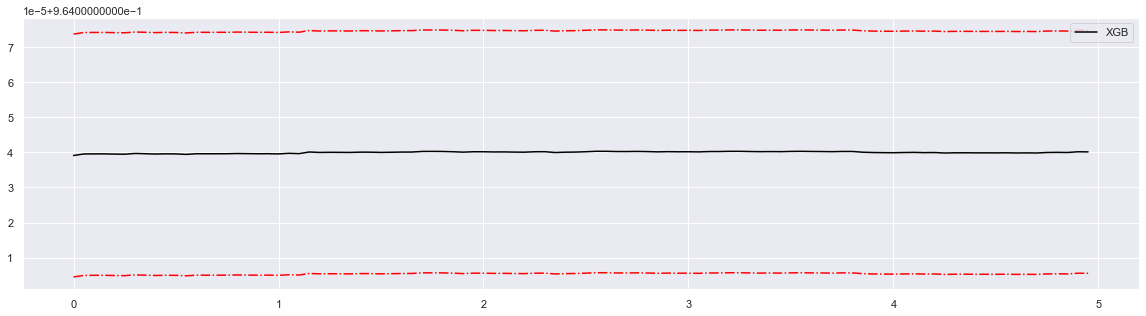

In [39]:
axisx=np.arange(0,5,0.05)
rs=[]
var=[]
ge=[]
for i in axisx:
    reg = XGBR(n_estimators=210,random_state=420,gamma=i)
    result=CVS(reg,X_train,y_train,cv=cv)
    rs.append(result.mean())
    var.append(result.var())
    ge.append((1-result.mean())**2+result.var())
print(axisx[rs.index(max(rs))],max(rs))
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
rs=np.array(rs)
var=np.array(var)*0.1
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c='Black',label='XGB')
plt.plot(axisx,rs+var,c="red",linestyle="-.")
plt.plot(axisx,rs-var,c="red",linestyle="-.")
plt.legend()
plt.show()

In [40]:
dtrain=xgb.DMatrix(X_train,y_train)
dtest=xgb.DMatrix(X_test,y_test)
param1={"silent":True,
        "obj":'reg:linear'
       ,'gamma':0}
num_round=210
n_fold=5

In [41]:
time0=time()
cvresult1=xgb.cv(param1,dtrain,num_round,n_fold)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))

[15:49:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "obj", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:49:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "obj", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:49:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp

In [42]:
cvresult1.head(5)

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1.224267e+06,20114.131226,1.231780e+06,84018.563272
1,8.801806e+05,13888.801547,8.945486e+05,67293.890109
2,6.373388e+05,9573.207570,6.621472e+05,56386.948781
3,4.648657e+05,6354.887192,5.025854e+05,46264.917285
4,3.415899e+05,4126.237977,3.911902e+05,41381.943805


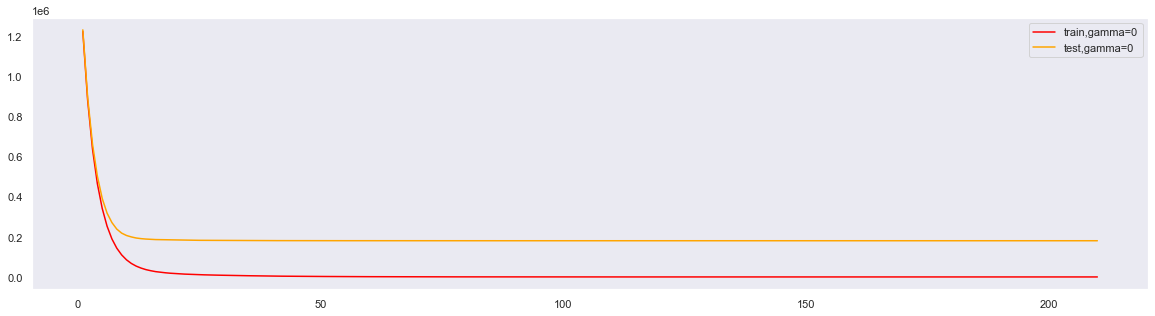

In [43]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(range(1,211),
         cvresult1.iloc[:,0],
         c='red',label='train,gamma=0')
plt.plot(range(1,211),
         cvresult1.iloc[:,2],
         c='orange',label='test,gamma=0')
plt.legend()
plt.show()

[15:49:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "obj", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:49:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "obj", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:49:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp

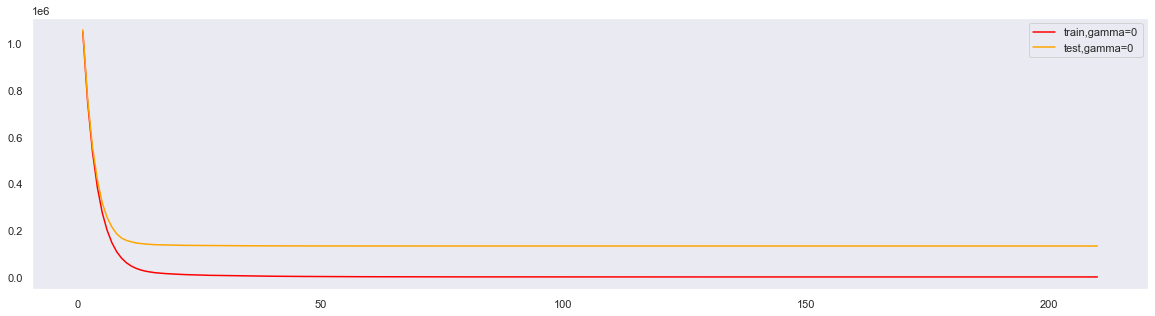

In [44]:
param1={"silent":True,
        "obj":'reg:linear'
       ,'gamma':0,"eval_metric":"mae"}
cvresult1=xgb.cv(param1,dtrain,num_round,n_fold)
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(range(1,211),
         cvresult1.iloc[:,0],
         c='red',label='train,gamma=0')
plt.plot(range(1,211),
         cvresult1.iloc[:,2],
         c='orange',label='test,gamma=0')
plt.legend()
plt.show()

## (full testing)

00:00:678441
00:00:385228
00:00:342235


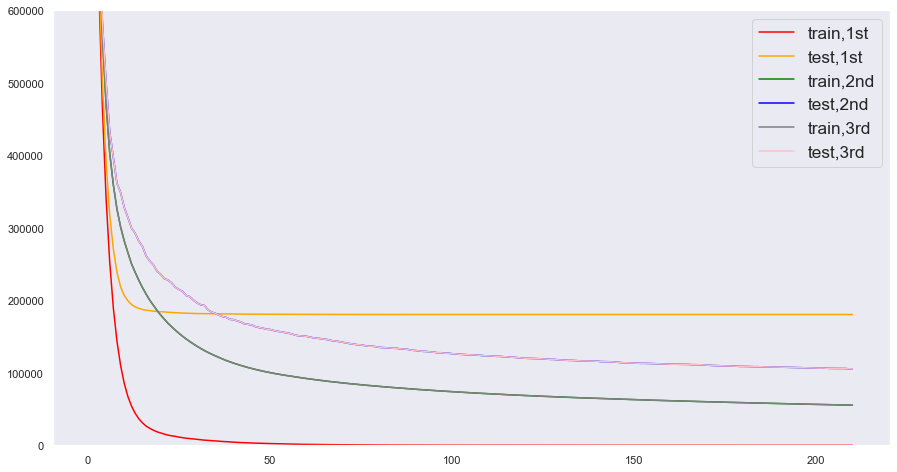

In [57]:
param1={'subsample':1
        ,'max_depth':6
        ,'eta':0.3
        ,'gamma':0
        ,'lambda':1
        ,'alpha':0
        ,'colsample_bytree':1
        ,'colsample_bylevel':1
        ,'colsample_bynode':1
       }
param2={'subsample':1
        ,'max_depth':1
        ,'eta':0.3
        ,'gamma':0.2
        ,'lambda':0.5
        ,'alpha':0
        ,'colsample_bytree':1
        ,'colsample_bylevel':1
        ,'colsample_bynode':1
       }
param3={'subsample':1
        ,'max_depth':1
        ,'eta':0.3
        ,'gamma':0.2
        ,'lambda':0.5
        ,'alpha':0
        ,'colsample_bytree':1
        ,'colsample_bylevel':1
        ,'colsample_bynode':1
       }
num_round=210
n_fold=5
time0=time()
cvresult1=xgb.cv(param1,dtrain,num_round,n_fold)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))

time0=time()
cvresult2=xgb.cv(param2,dtrain,num_round,n_fold)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))

time0=time()
cvresult3=xgb.cv(param3,dtrain,num_round,n_fold)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))

fig,ax=plt.subplots(1,figsize=(15,8))
ax.grid()
ax.set_ylim(top=600000)
ax.plot(range(1,211),
         cvresult1.iloc[:,0],
         c='red',label='train,1st')
ax.plot(range(1,211),
         cvresult1.iloc[:,2],
         c='orange',label='test,1st')
ax.plot(range(1,211),
         cvresult2.iloc[:,0],
         c='green',label='train,2nd')
ax.plot(range(1,211),
         cvresult2.iloc[:,2],
         c='blue',label='test,2nd')
ax.plot(range(1,211),
         cvresult3.iloc[:,0],
         c='gray',label='train,3rd')
ax.plot(range(1,211),
         cvresult3.iloc[:,2],
         c='pink',label='test,3rd')
ax.legend(fontsize="x-large")
plt.show()

## Save data and run

In [58]:
import pickle

In [59]:
dtrain=xgb.DMatrix(X_train,y_train)

In [60]:
param={'subsample':1
        ,'max_depth':1
        ,'eta':0.3
        ,'gamma':0.2
        ,'lambda':0.5
        ,'alpha':0
        ,'colsample_bytree':1
        ,'colsample_bylevel':1
        ,'colsample_bynode':1
       }
num_round=210
n_fold=5

In [61]:
bst=xgb.train(param,dtrain,num_round)

In [62]:
pickle.dump(bst,open("xgboostOthers.dat","wb"))